# ZECMIP Signal To Noise

The notebook calculations
- Signal to noise for individual models for a range of differnet window length
- The fraction of models that are stable for a range of different window length

In [1]:
import xarray as xr
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
import cftime
from glob import glob
from typing import List
import warnings
import json
warnings.filterwarnings('ignore')
import matplotlib as mpl
import constants
sys.path.append(constants.MODULE_DIR)
import json
# Custom plots for signal to noise functions.
import open_ds
import xarray_class_accessors as xca
warnings.filterwarnings('ignore')
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import sn_plotting
import xarray_extender as xe

In [57]:
import matplotlib
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

import matplotlib.pylab as pylab

params = {'axes.labelsize' : 'x-large',
         'legend.fontsize': 'x-large',
          'axes.titlesize': 'x-large',
         }

pylab.rcParams.update(params)

In [3]:
variable = 'tas'
notebook_number = 'zec_03'

In [4]:
open_kwargs = dict(use_cftime=True, concat_dim='model', combine='nested', 
                  chunks = {'lat': 100, 'lon': 100, 'time': -1})

In [5]:
experiment_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', '4xCO2', '*.nc')).compute()

picontrol_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol', '*.nc'), 
                  use_cftime=True, concat_dim='model', combine='nested').compute()
experiment_ds

<xarray.Dataset>
Dimensions:  (time: 330, model: 8, lat: 96, lon: 192)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0330-12-31 00:00:00
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    tas      (time, model, lat, lon) float32 228.2 228.1 228.0 ... 265.1 265.1

# Signal to Noise (latest)

In [7]:
# Only 150 years shared between all dataaset
experiment_ds = experiment_ds.isel(time=slice(0, 150)).sel(model = constants.ZECMIP_MODELS)
picontrol_ds = picontrol_ds.sel(model = constants.ZECMIP_MODELS)
experiment_ds

<xarray.Dataset>
Dimensions:  (time: 150, model: 6, lat: 96, lon: 192)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0150-12-31 00:00:00
  * model    (model) object 'CESM2' 'GFDL-ESM4' ... 'UKESM1-0-LL'
    height   float64 2.0
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    tas      (time, model, lat, lon) float32 228.2 228.1 228.0 ... 265.4 265.4

In [8]:
experiment_ds

<xarray.Dataset>
Dimensions:  (time: 150, model: 6, lat: 96, lon: 192)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0150-12-31 00:00:00
  * model    (model) object 'CESM2' 'GFDL-ESM4' ... 'UKESM1-0-LL'
    height   float64 2.0
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    tas      (time, model, lat, lon) float32 228.2 228.1 228.0 ... 265.4 265.4

In [9]:
# Control space mean
control_ds_mean = picontrol_ds.clima_ds.space_mean()

# experiment_smean_ds, control_ds_mean = sn.calculate_global_value(experiment_ds, picontrol_ds, 
#                                                                 variable='tas') 
# experiment_smean_ds

In [10]:
# Calculating the anomalies
experiment_anom_ds = experiment_ds.clima_ds.anomalies(picontrol_ds)
# Space mean of anomalies
experiment_smean_ds = experiment_anom_ds.clima_ds.space_mean()
experiment_smean_ds = experiment_smean_ds.compute()
experiment_smean_ds

tas, 

<xarray.Dataset>
Dimensions:  (time: 150, model: 6)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0150-12-31 00:00:00
  * model    (model) object 'CESM2' 'GFDL-ESM4' ... 'UKESM1-0-LL'
    height   float64 2.0
Data variables:
    tas      (time, model) float64 1.923 1.328 1.91 1.264 ... 0.8469 1.236 2.909

In [11]:
RUN_PARAMS = dict( start_window = 3, end_window = 50, step_window = 1)
RUN_PARAMS

{'start_window': 3, 'end_window': 50, 'step_window': 1}

In [12]:
# unstable_sn_da , stable_sn_da = sn.sn_multi_window(
#             experiment_smean_ds.tas.dropna(dim='time'), control_ds_mean, **RUN_PARAMS, parallel=True)


stable_sn_ds, unstable_sn_ds = experiment_smean_ds.sn_ds.sn_multiwindow(
    control_ds_mean, parallel=True, **RUN_PARAMS)

- 
====tas


Experiment
--------

range(3, 50)
3, 5, 4, 6, 7, 13, 10, 9, 8, 11, 14, 12, 15, 18, 17, 16, 19, 20, 21, 22, 23, 24, 27, 25, 26, 29, 28, 30, 31, 32, 33, 34, 35, 37, 36, 38, 39, 40, 41, 42, 44, 43, 45, 46, 47, 48, 49, 
Control
------

range(3, 50)
4, 3, 5, 6, 8, 11, 7, 9, 12, 15, 16, 13, 18, 14, 17, 10, 19, 20, 24, 23, 22, 21, 25, 26, 27, 28, 29, 31, 32, 30, 33, 34, 35, 36, 37, 39, 38, 40, 42, 41, 43, 45, 46, 44, 48, 47, 49, 

In [13]:
unstable_sn_ds

<xarray.Dataset>
Dimensions:  (time: 148, model: 6, window: 47)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0148-12-31 00:00:00
  * model    (model) object 'CESM2' 'GFDL-ESM4' ... 'UKESM1-0-LL'
    height   float64 2.0
  * window   (window) int64 3 4 5 6 7 8 9 10 11 ... 41 42 43 44 45 46 47 48 49
Data variables:
    tas      (window, time, model) float64 3.82 4.341 nan nan ... nan nan nan

In [14]:
stable_point_ds = sn.get_dataset_stable_year_multi_window(unstable_sn_ds, max_effective_length=100)
stable_point_ds

Replacing points greater than 100 with 101


<xarray.Dataset>
Dimensions:   (model: 6, window: 47, variable: 1)
Coordinates:
  * model     (model) object 'CESM2' 'GFDL-ESM4' ... 'UKESM1-0-LL'
    height    float64 2.0
  * window    (window) int64 3 4 5 6 7 8 9 10 11 ... 41 42 43 44 45 46 47 48 49
  * variable  (variable) <U3 'tas'
Data variables:
    time      (variable, window, model) int64 1 1 0 0 1 0 ... 32 33 32 60 14 65

In [15]:
# Extracting the increasing and decreasing singal to noise trends in
unstable_increaseing_sn_ds = unstable_sn_ds[['tas']].where(unstable_sn_ds[['tas']] > 0)
unstable_decreaseing_sn_ds = unstable_sn_ds[['tas']].where(unstable_sn_ds[['tas']] < 0)

In [16]:
unstable_increaseing_sn_number = unstable_increaseing_sn_ds.count(dim='model')
unstable_decreaseing_sn_number = unstable_decreaseing_sn_ds.count(dim='model')

unstable_increaseing_sn_number

<xarray.Dataset>
Dimensions:  (window: 47, time: 148)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0148-12-31 00:00:00
    height   float64 2.0
  * window   (window) int64 3 4 5 6 7 8 9 10 11 ... 41 42 43 44 45 46 47 48 49
Data variables:
    tas      (window, time) int64 3 0 0 1 1 0 0 1 1 2 0 ... 0 0 0 0 0 0 0 0 0 0

In [17]:
# Chaging the model dimensino from a coordinate to a data variable. This is done as most functions are 
# set up this way
experiment_smean_ds_dvar = xce.convert_dimension_to_data_vars(experiment_smean_ds.tas, dim='model')
experiment_smean_ds_dvar

<xarray.Dataset>
Dimensions:         (time: 150)
Coordinates:
  * time            (time) object 0001-12-31 00:00:00 ... 0150-12-31 00:00:00
    model           <U5 'CESM2'
    height          float64 2.0
Data variables:
    CESM2           (time) float64 1.923 2.075 2.073 1.877 ... 1.949 2.064 1.773
    GFDL-ESM4       (time) float64 1.328 1.395 1.489 1.408 ... 1.217 1.195 1.229
    GISS-E2-1-G-CC  (time) float64 1.91 1.852 1.598 1.579 ... 1.94 1.986 1.651
    MIROC-ES2L      (time) float64 1.264 1.373 1.568 ... 1.143 0.8722 0.8469
    MPI-ESM1-2-LR   (time) float64 1.451 1.519 1.597 1.491 ... 1.256 1.3 1.236
    UKESM1-0-LL     (time) float64 2.662 2.81 2.8 2.824 ... 2.872 2.867 2.909

# Plots

In [18]:
variable = 'tas'
units = constants.VARIABLE_INFO[variable]["units"]
longname = constants.VARIABLE_INFO[variable]['longname']
hemisphere_title = 'Global'
print(f'{longname=}', f'{units=}', sep=' , ')

longname='Near-Surface Air Temperature' , units='$^{\\circ}C$'


In [19]:
stable_point_ds

<xarray.Dataset>
Dimensions:   (model: 6, window: 47, variable: 1)
Coordinates:
  * model     (model) object 'CESM2' 'GFDL-ESM4' ... 'UKESM1-0-LL'
    height    float64 2.0
  * window    (window) int64 3 4 5 6 7 8 9 10 11 ... 41 42 43 44 45 46 47 48 49
  * variable  (variable) <U3 'tas'
Data variables:
    time      (variable, window, model) int64 1 1 0 0 1 0 ... 32 33 32 60 14 65

In [20]:
models = stable_point_ds.model.values

In [21]:
max_effective_length = 100

/home/563/ab2313/gdata/images/PhD/top_level/zec_03_tas_all_models_stable_year.png


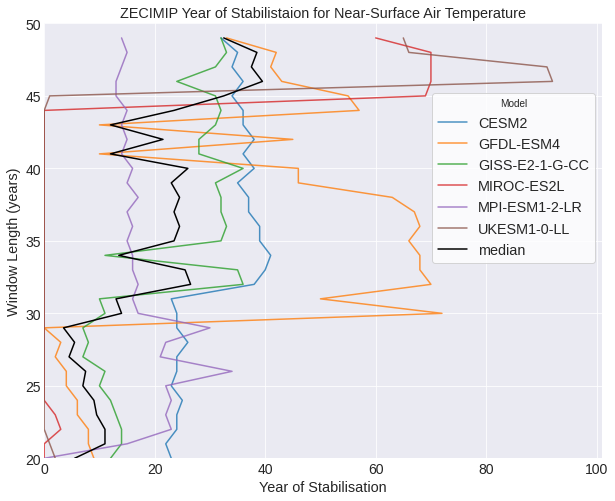

In [22]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111)

for model in models:
    da = stable_point_ds.sel(model=model).time.plot(ax=ax,y='window', linewidth=1.5, alpha=0.8,
                                                    label=model)
    
stable_point_ds.median(dim='model').time.plot(ax=ax,y='window', label='median', color='k', linewidth=1.5) 

ax.set_xlim(0, max_effective_length + 1)
ax.set_ylim(20, 50)
leg = ax.legend(ncol=1, bbox_to_anchor=[1, 0.857], frameon=True, facecolor='white')
leg.set_title('Model')
leg.get_title().set_fontsize('10')
title = f'ZECIMIP Year of Stabilistaion for {constants.VARIABLE_INFO[variable]["longname"]}'
ax.set_title(title)
ax.set_xlabel('Year of Stabilisation')
ax.set_ylabel('Window Length (years)')

save_name = os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{notebook_number}_{variable}_all_models_stable_year.png')
print(save_name)
fig.savefig(save_name, bbox_inches='tight', dpi=200)

In [ ]:
longname = 'Near-Surface\nAir Temperature'

CESM2
- No matching models found data_vars=['tas']
Saving /home/563/ab2313/gdata/images/PhD/top_level/zec_03_CESM2_sn_multi_window.png
GFDL-ESM4
- No matching models found data_vars=['tas']
Saving /home/563/ab2313/gdata/images/PhD/top_level/zec_03_GFDL-ESM4_sn_multi_window.png
GISS-E2-1-G-CC
- No matching models found data_vars=['tas']
Saving /home/563/ab2313/gdata/images/PhD/top_level/zec_03_GISS-E2-1-G-CC_sn_multi_window.png
MIROC-ES2L
- No matching models found data_vars=['tas']
Saving /home/563/ab2313/gdata/images/PhD/top_level/zec_03_MIROC-ES2L_sn_multi_window.png
MPI-ESM1-2-LR
- No matching models found data_vars=['tas']
Saving /home/563/ab2313/gdata/images/PhD/top_level/zec_03_MPI-ESM1-2-LR_sn_multi_window.png
UKESM1-0-LL
- No matching models found data_vars=['tas']
Saving /home/563/ab2313/gdata/images/PhD/top_level/zec_03_UKESM1-0-LL_sn_multi_window.png


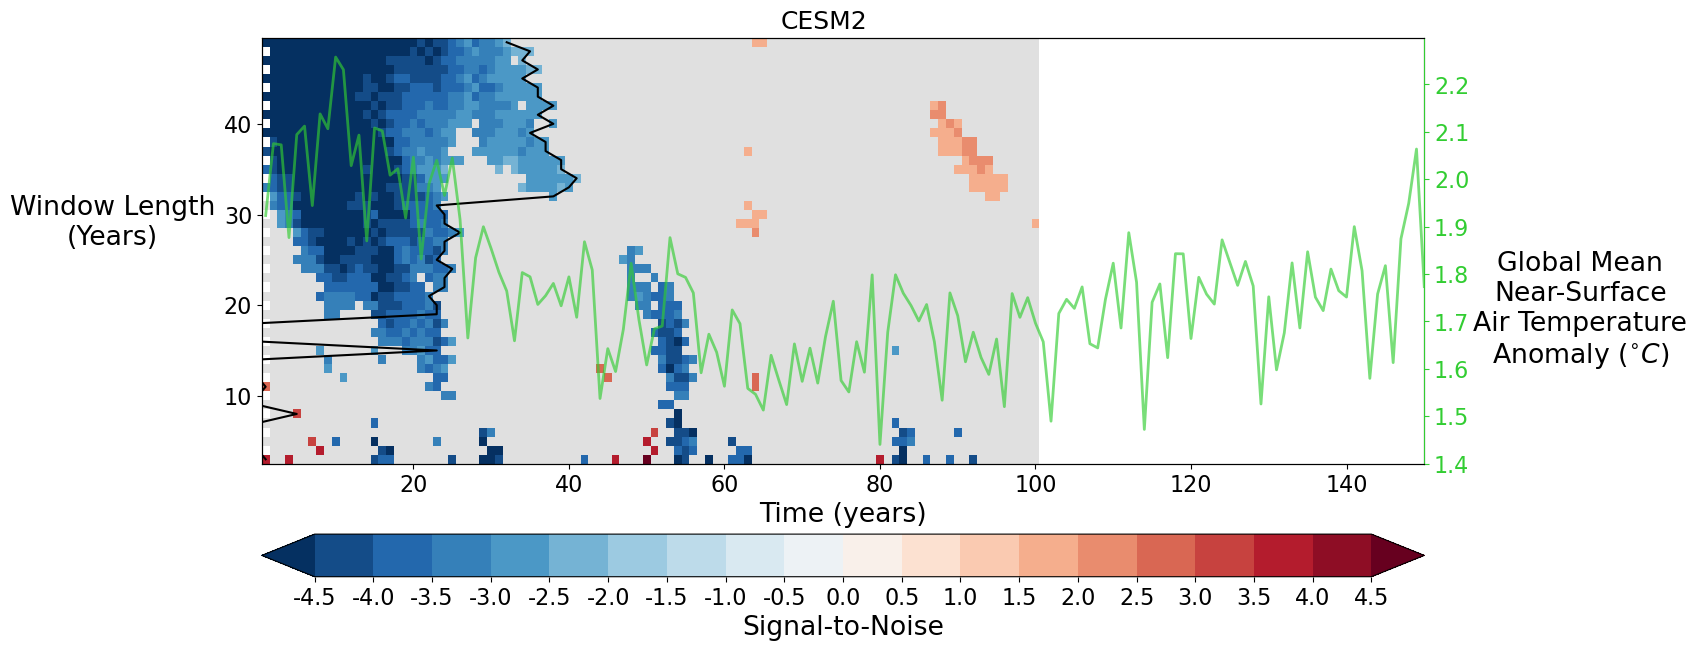

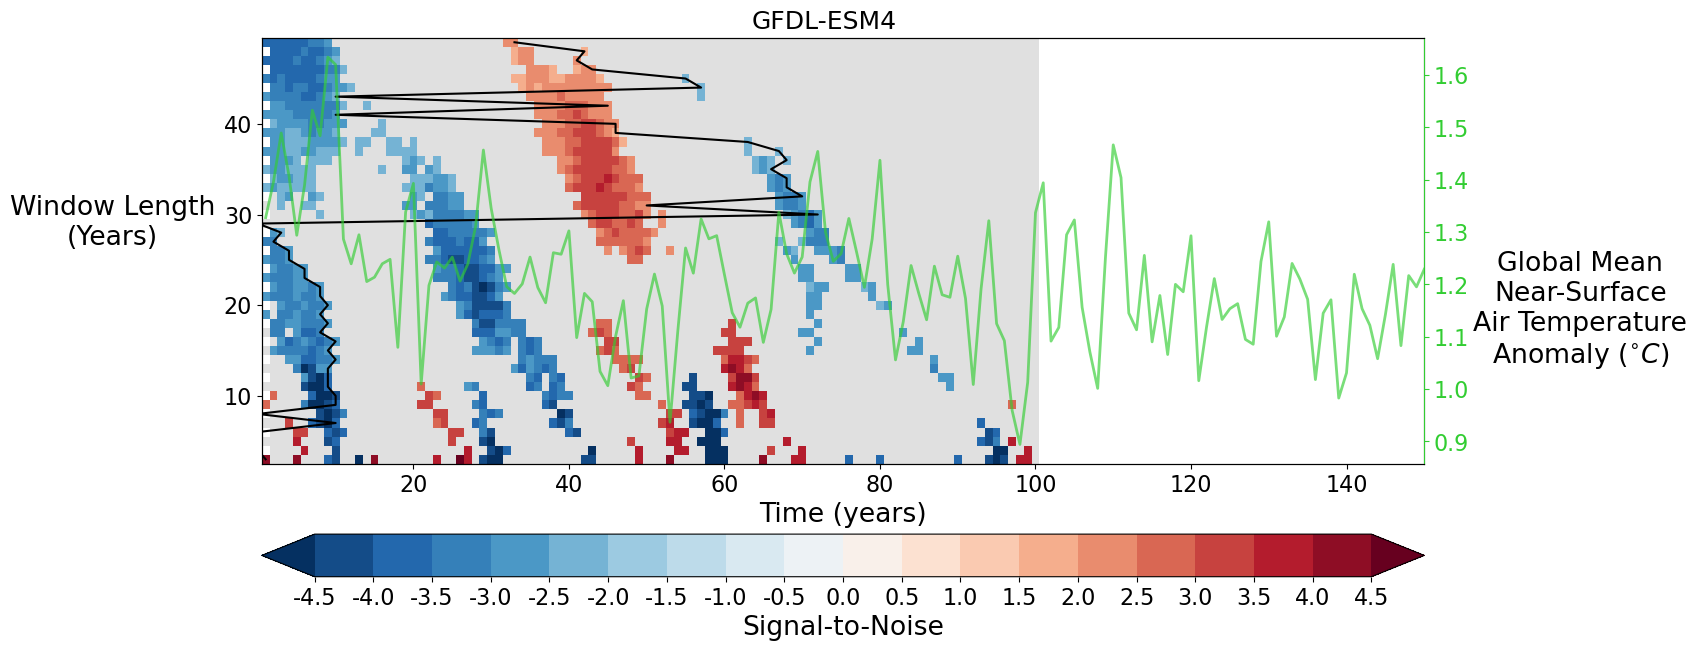

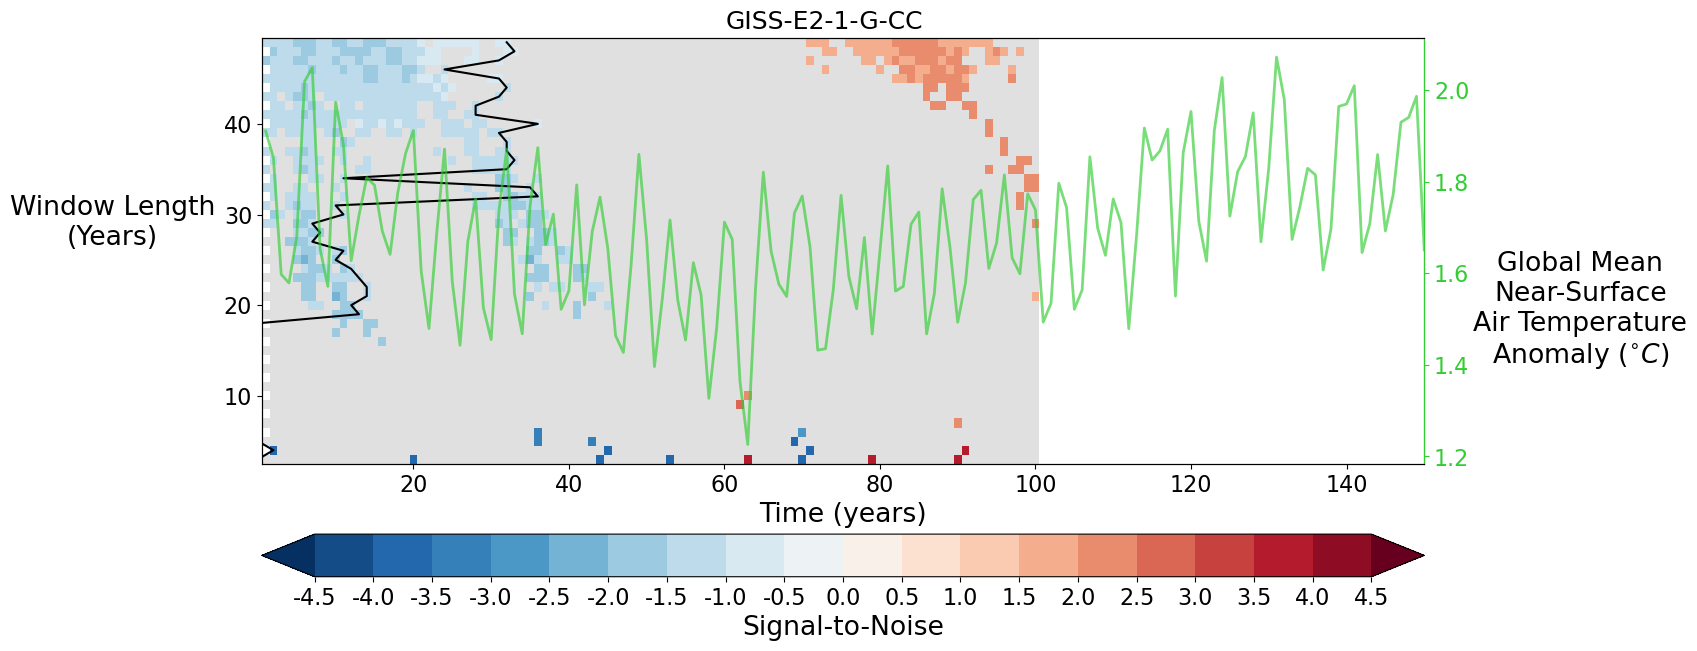

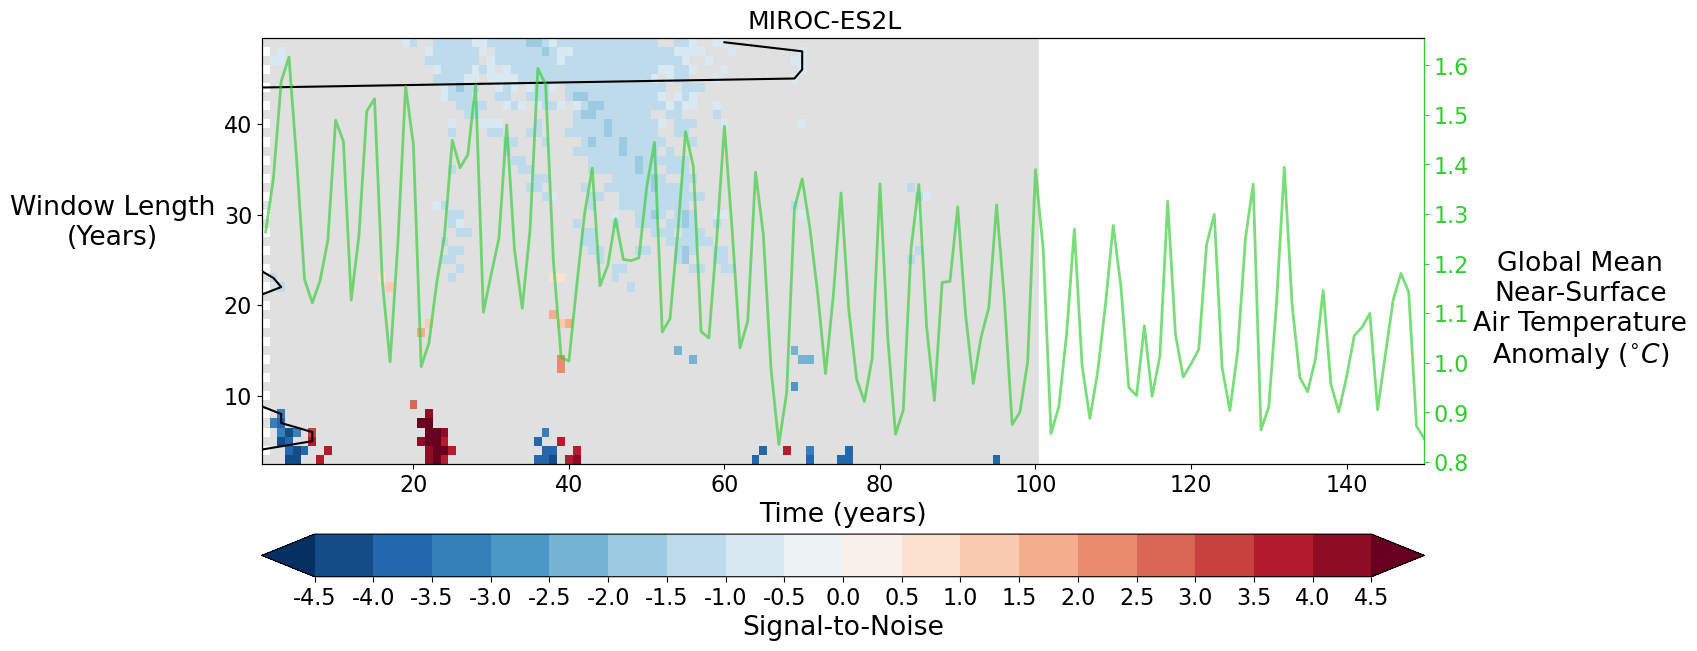

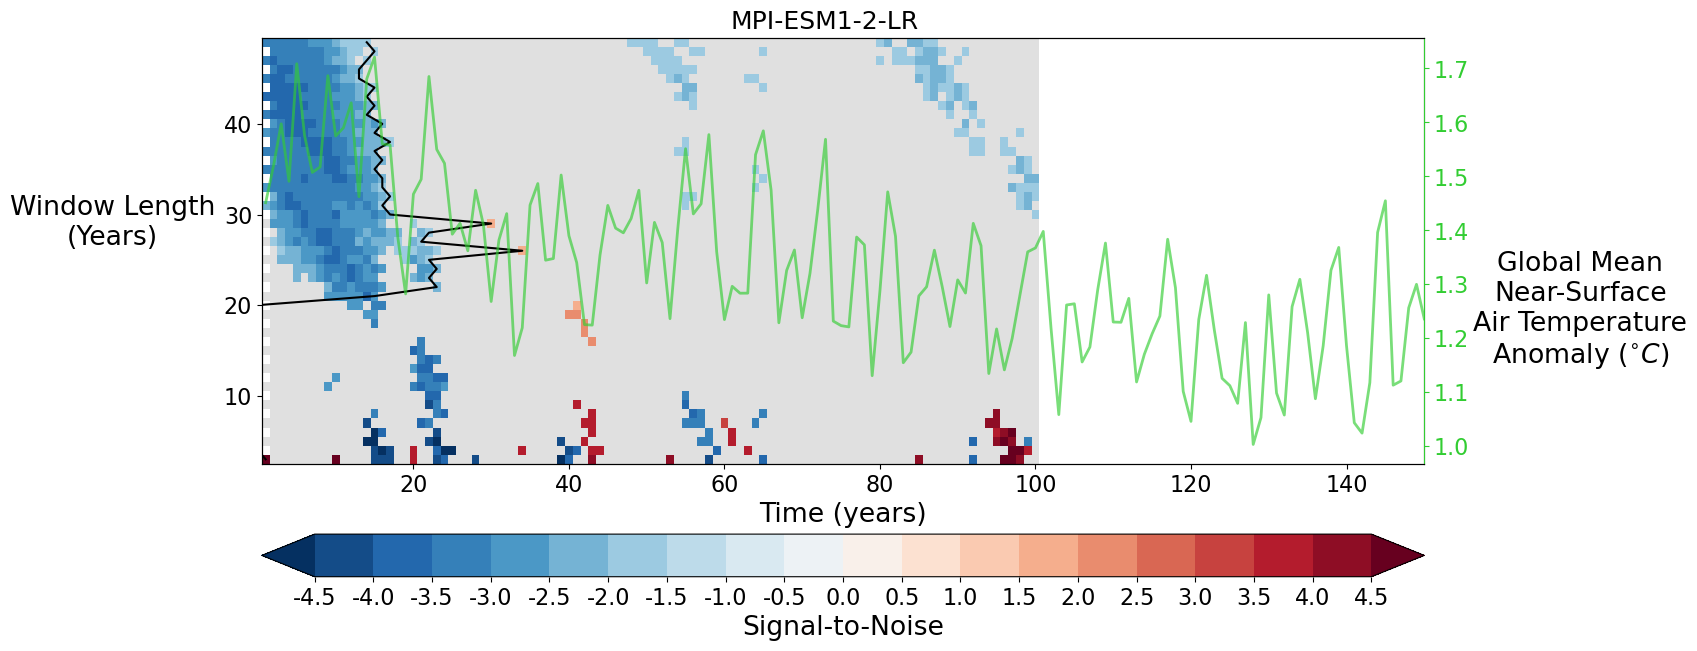

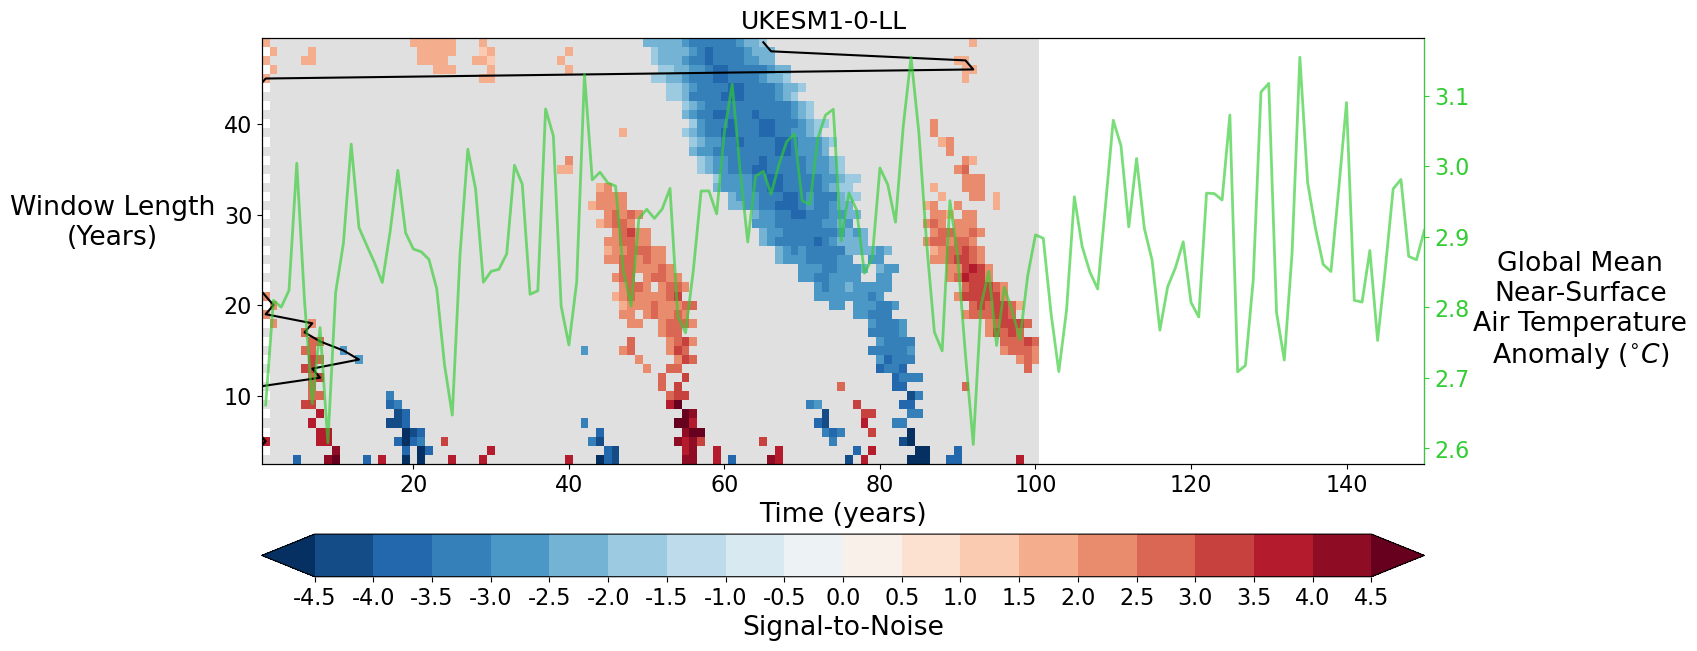

In [95]:
reload(sn_plotting)
mpl.rcParams.update(mpl.rcParamsDefault)

# Looping through all the models in our resultant dicionary and printing the result. 
for model in unstable_sn_ds.model.values:
    print(model)
    (fig, ax1, ax2, ax3, cbar) = sn_plotting.sn_multi_window_in_time(
                            unstable_sn_ds.sel(model=model)['tas'].isel(time=slice(None, 100)), 
                            stable_sn_ds.sel(model=model)['tas'].isel(time=slice(None, 100)),
                            experiment_smean_ds.sel(model=model).dropna(dim='time'),
                            stable_point_ds=stable_point_ds.sel(model=model),
                            ax2_ylabel = f'{hemisphere_title} Mean\n{longname}\nAnomaly ({units})',
                            xupperlim = 150,
                            title=model, step=0.5, vmax=4.5, vmin=-4.5, font_scale=0.8);

    save_name = f'{constants.IMAGE_SAVE_DIR_TOP_LEVEL}/{notebook_number}_{model}_sn_multi_window.png'
    print(f'Saving {save_name}')
    fig.savefig(save_name, dpi=400, bbox_inches='tight')

Saving /home/563/ab2313/gdata/images/PhD/top_level/zec_03_MPI-ESM1-2-LR_first_20_years.png


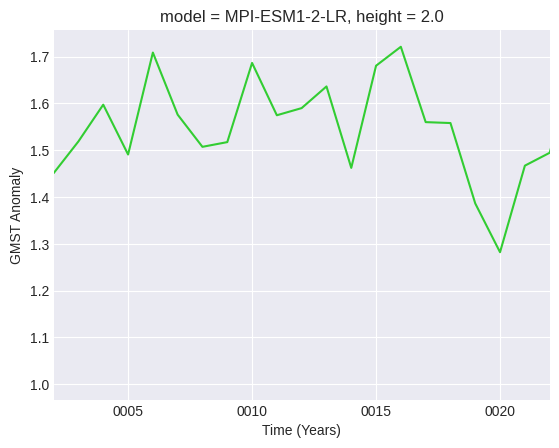

In [50]:
model = 'MPI-ESM1-2-LR'
length = 20


fig = plt.figure()
ax = fig.add_subplot(111)
experiment_smean_ds.sel(model=model).tas.plot(ax=ax, c='limegreen')
time = experiment_smean_ds.time.values
ax.set_xlim(time[0],time[length])
ax.set_xlabel('Time (Years)')
ax.set_ylabel('GMST Anomaly')

save_name = f'{constants.IMAGE_SAVE_DIR_TOP_LEVEL}/{notebook_number}_{model}_first_{length}_years.png'
print(f'Saving {save_name}')
fig.savefig(save_name, dpi=400, bbox_inches='tight')

- No matching models found data_vars=['CESM2', 'GFDL-ESM4', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'UKESM1-0-LL']
Saving /home/563/ab2313/gdata/images/PhD/top_level/zecmip_03_all_models_fraction_decrasing_unstable_SN_multi_window.png


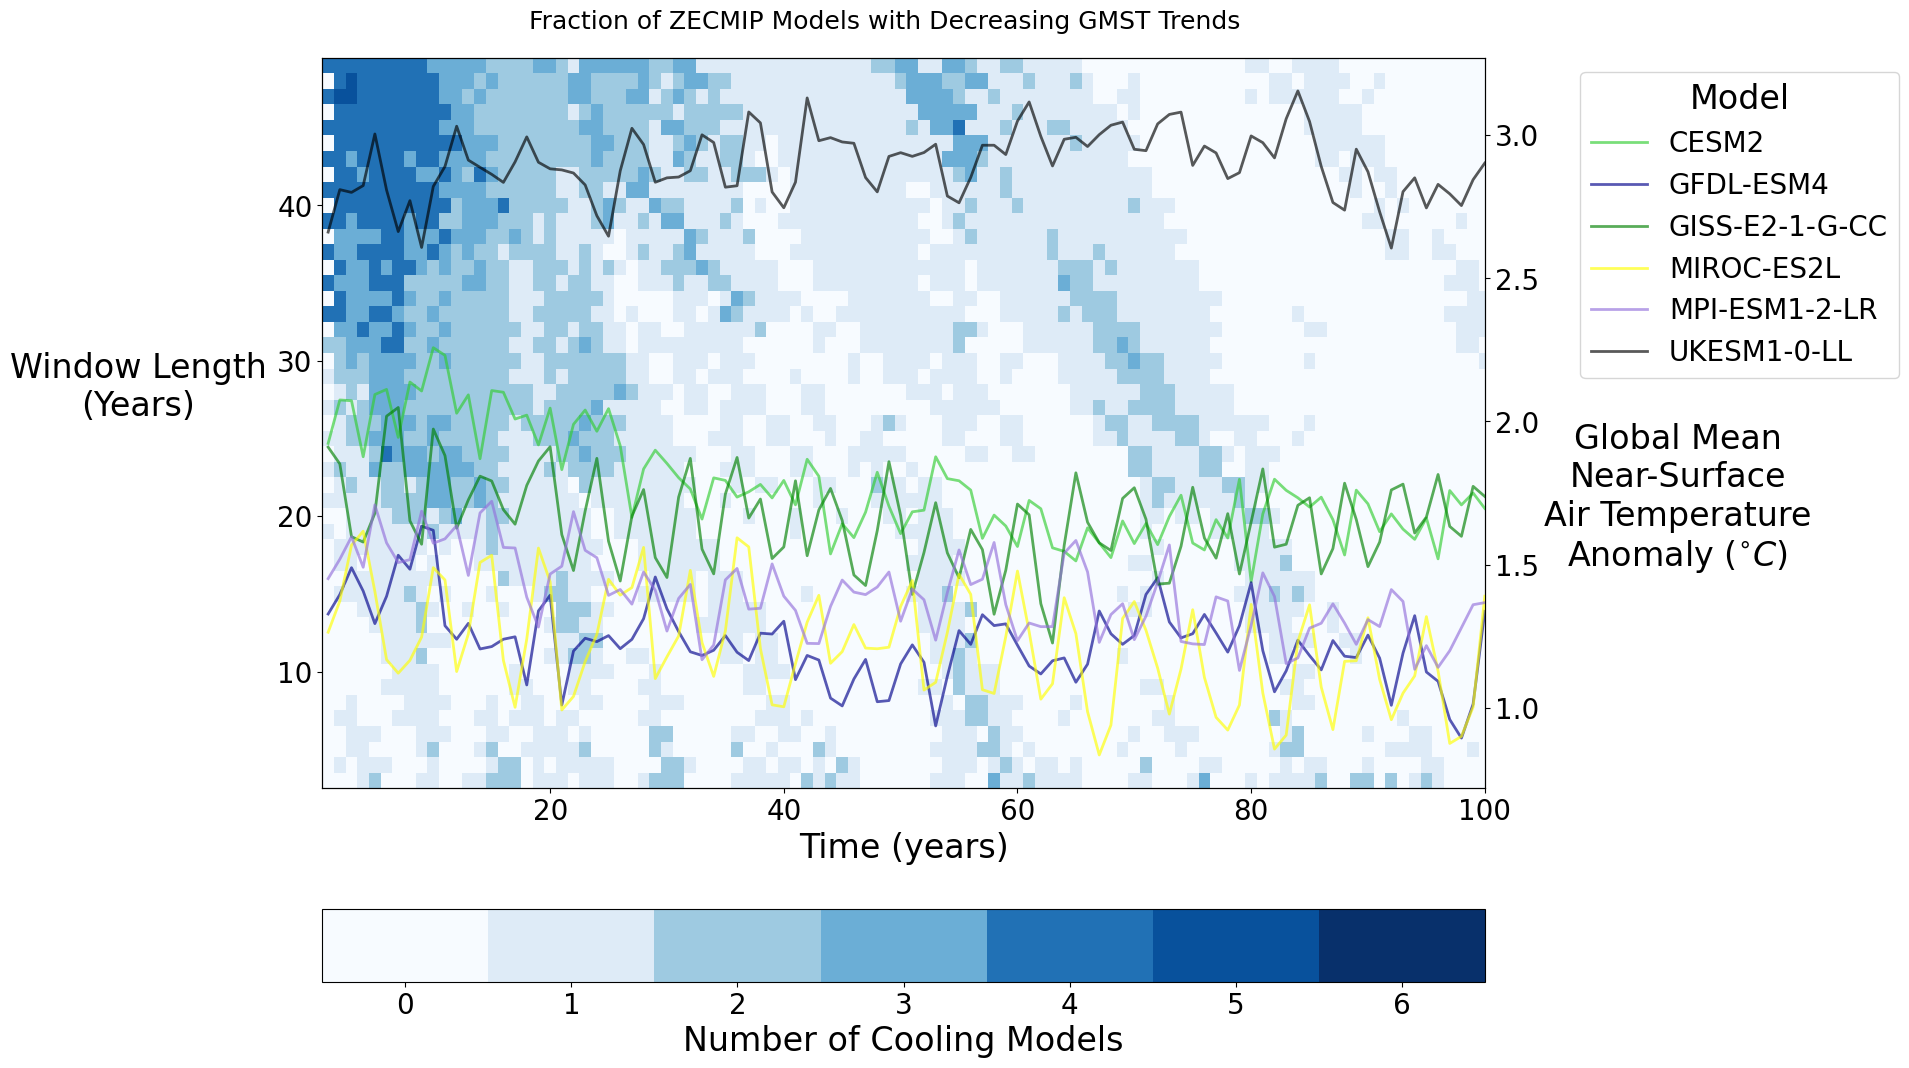

In [87]:
mpl.rcParams.update(mpl.rcParamsDefault)
reload(sn_plotting)
fig, ax1, ax2, ax3,cbar = sn_plotting.sn_multi_window_in_time(
    unstable_decreaseing_sn_number.tas,
    stable_sn_ds.tas.count(dim='model'), 
    experiment_smean_ds_dvar, 
    logginglevel='ERROR', 
    hieght = 15, width = 12,
    vmin=0, vmax=len(stable_sn_ds.model.values)+1, step=1, cbartick_offset = 0.5,
    cmap='Blues',
    extend='neither', xupperlim = 100,
    cbar_label= 'Number of Cooling Models', 
    ax2_ylabel  = f'{hemisphere_title} Mean\n{longname}\nAnomaly ({units})',
    title = f'Fraction of ZECMIP Models with Decreasing GMST Trends', cbar_ncols = 5, filter_max=True)



save_name = f'{constants.IMAGE_SAVE_DIR_TOP_LEVEL}/zecmip_03_all_models_fraction_decrasing_unstable_SN_multi_window.png'
print(f'Saving {save_name}')
fig.savefig(save_name, dpi=400, bbox_inches='tight')

- No matching models found data_vars=['CESM2', 'GFDL-ESM4', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'UKESM1-0-LL']
Saving /home/563/ab2313/gdata/images/PhD/top_level/zecmip_03_all_models_fraction_increasing_unstable_SN_multi_window.png


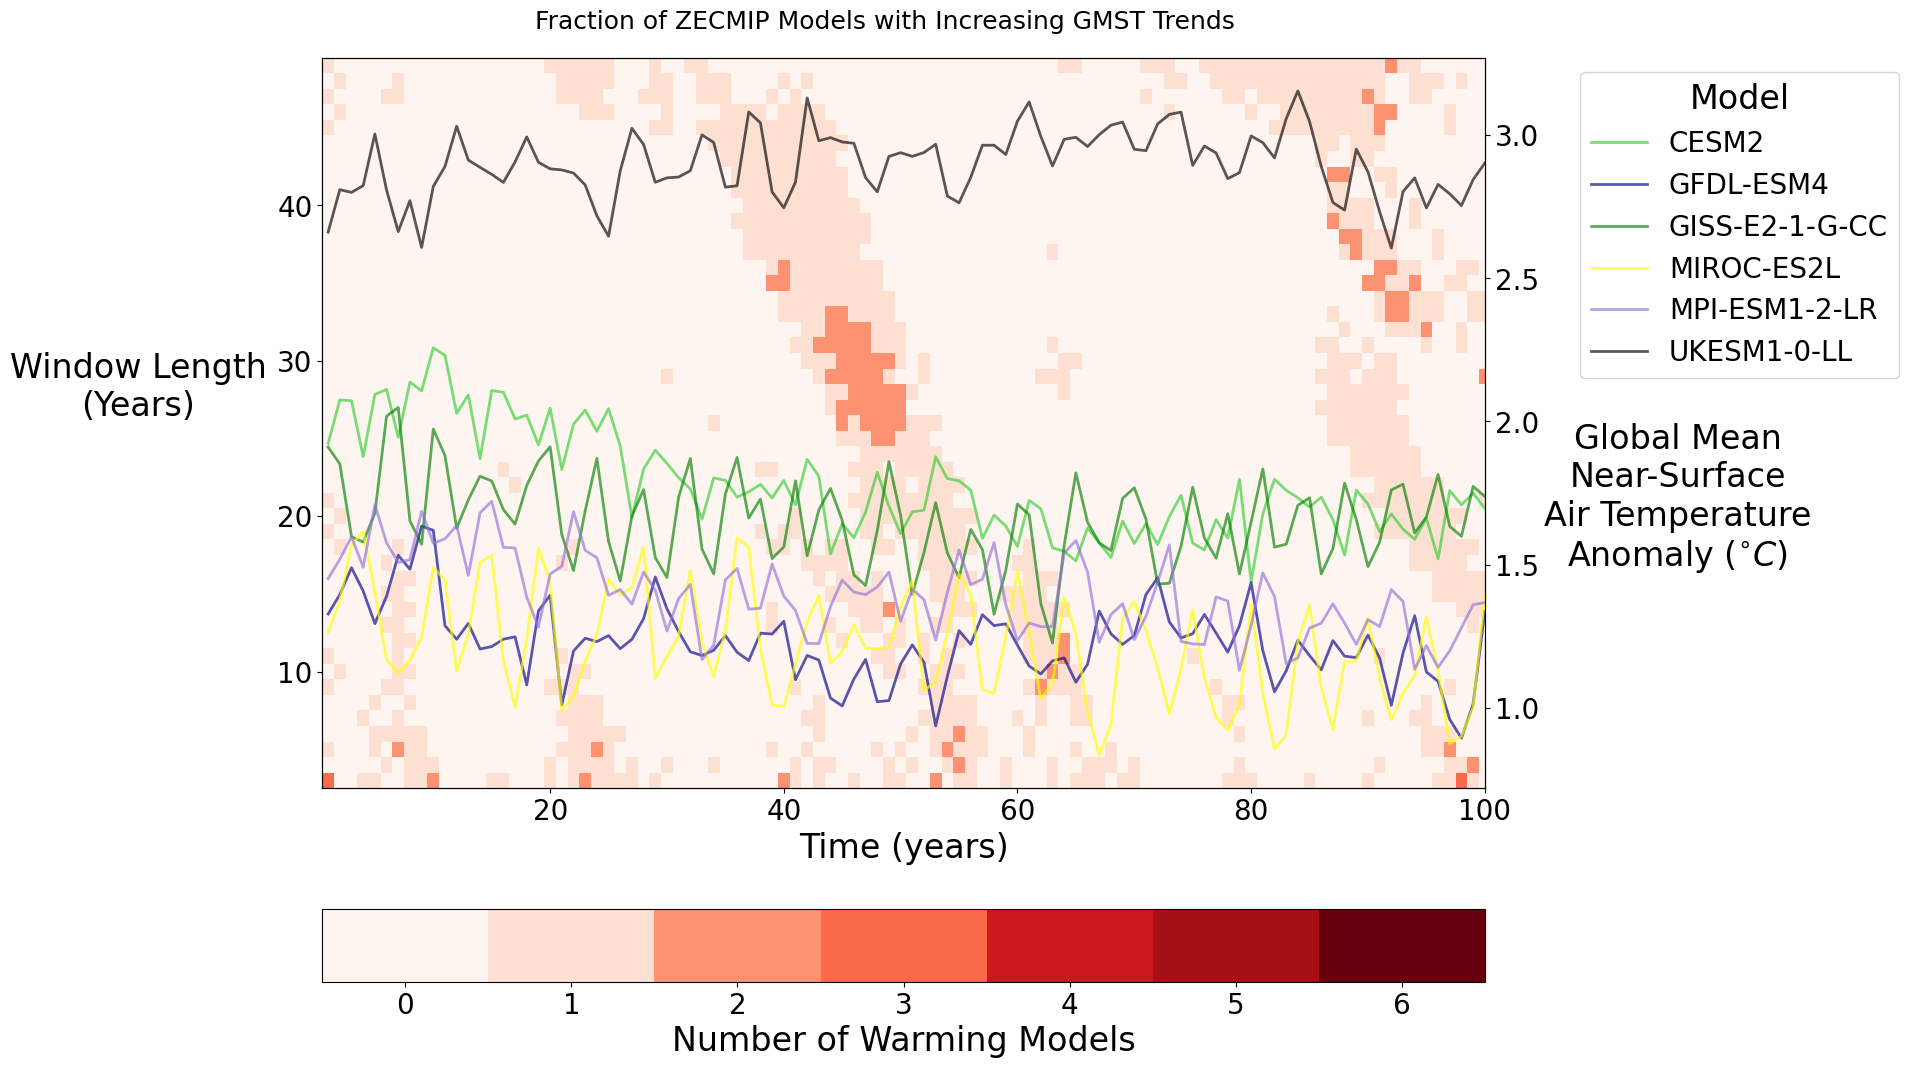

In [88]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax1, ax2, ax3,cbar = sn_plotting.sn_multi_window_in_time(
    unstable_increaseing_sn_number.tas,
    stable_sn_ds.tas.count(dim='model'), 
    experiment_smean_ds_dvar, 
    logginglevel='ERROR', 
    hieght = 15, width = 12,
    vmin=0, vmax=len(stable_sn_ds.model.values)+1, step=1, cbartick_offset = 0.5,
    cmap='Reds',
    extend='neither', xupperlim = 100,
    cbar_label= 'Number of Warming Models', 
    ax2_ylabel = f'{hemisphere_title} Mean\n{longname}\nAnomaly ({units})',
    title = f'Fraction of ZECMIP Models with Increasing GMST Trends', cbar_ncols = 5, filter_max=True)

save_name = f'{constants.IMAGE_SAVE_DIR_TOP_LEVEL}/zecmip_03_all_models_fraction_increasing_unstable_SN_multi_window.png'
print(f'Saving {save_name}')
fig.savefig(save_name, dpi=400, bbox_inches='tight')

In [26]:
control_ds_mean

<xarray.Dataset>
Dimensions:  (time: 1200, model: 6)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * model    (model) object 'CESM2' 'GFDL-ESM4' ... 'UKESM1-0-LL'
    height   float64 2.0
Data variables:
    tas      (time, model) float64 287.0 286.5 286.9 288.1 ... nan nan nan nan

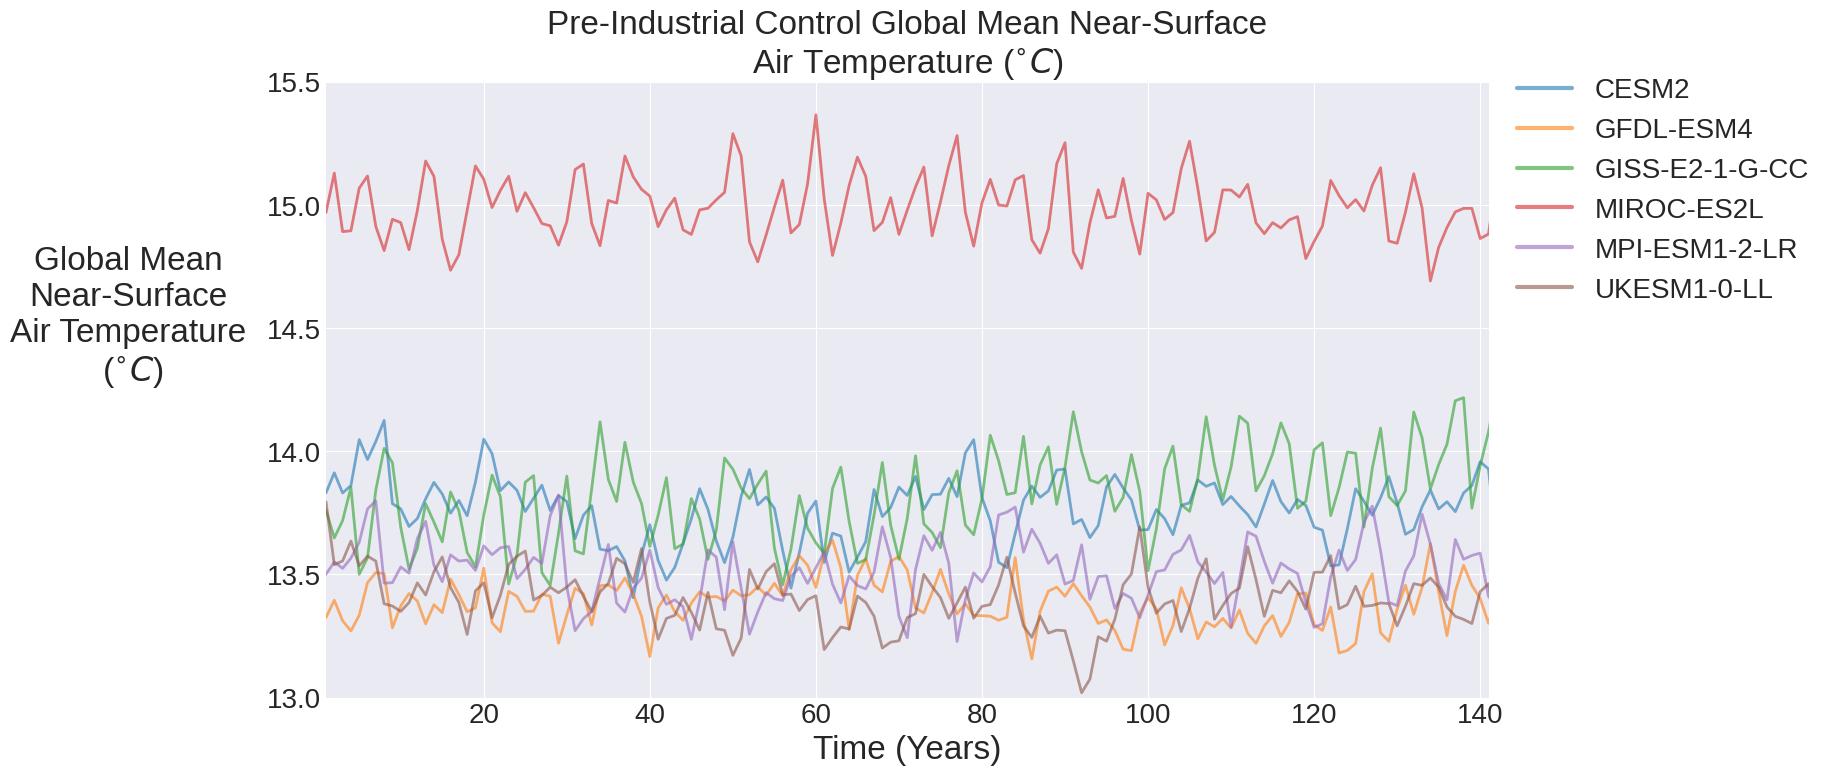

In [114]:

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = control_ds_mean['time'].values
years = [t.year for t in time]
for model in list(control_ds_mean.model.values):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, control_ds_mean.sel(model=model).tas.values - 273.15, label=model, **plot_kwargs)
    
ax.set_ylabel(f'{hemisphere_title} Mean\n{longname}\n ({units})', size=24, labelpad=100, rotation=0)
ax.set_xlabel('Time (Years)', size=24)
ax.set_xlim(years[0], years[140])
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
leg = ax.legend(ncol = 1, fontsize=20, bbox_to_anchor=[1.15,0.6])
ax.set_ylim(13, 15.5)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title(f'Pre-Industrial Control {hemisphere_title} Mean {longname} ({units})', fontsize=24);

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 'zec_03__multi_model_picontrol.png'),
bbox_inches='tight')

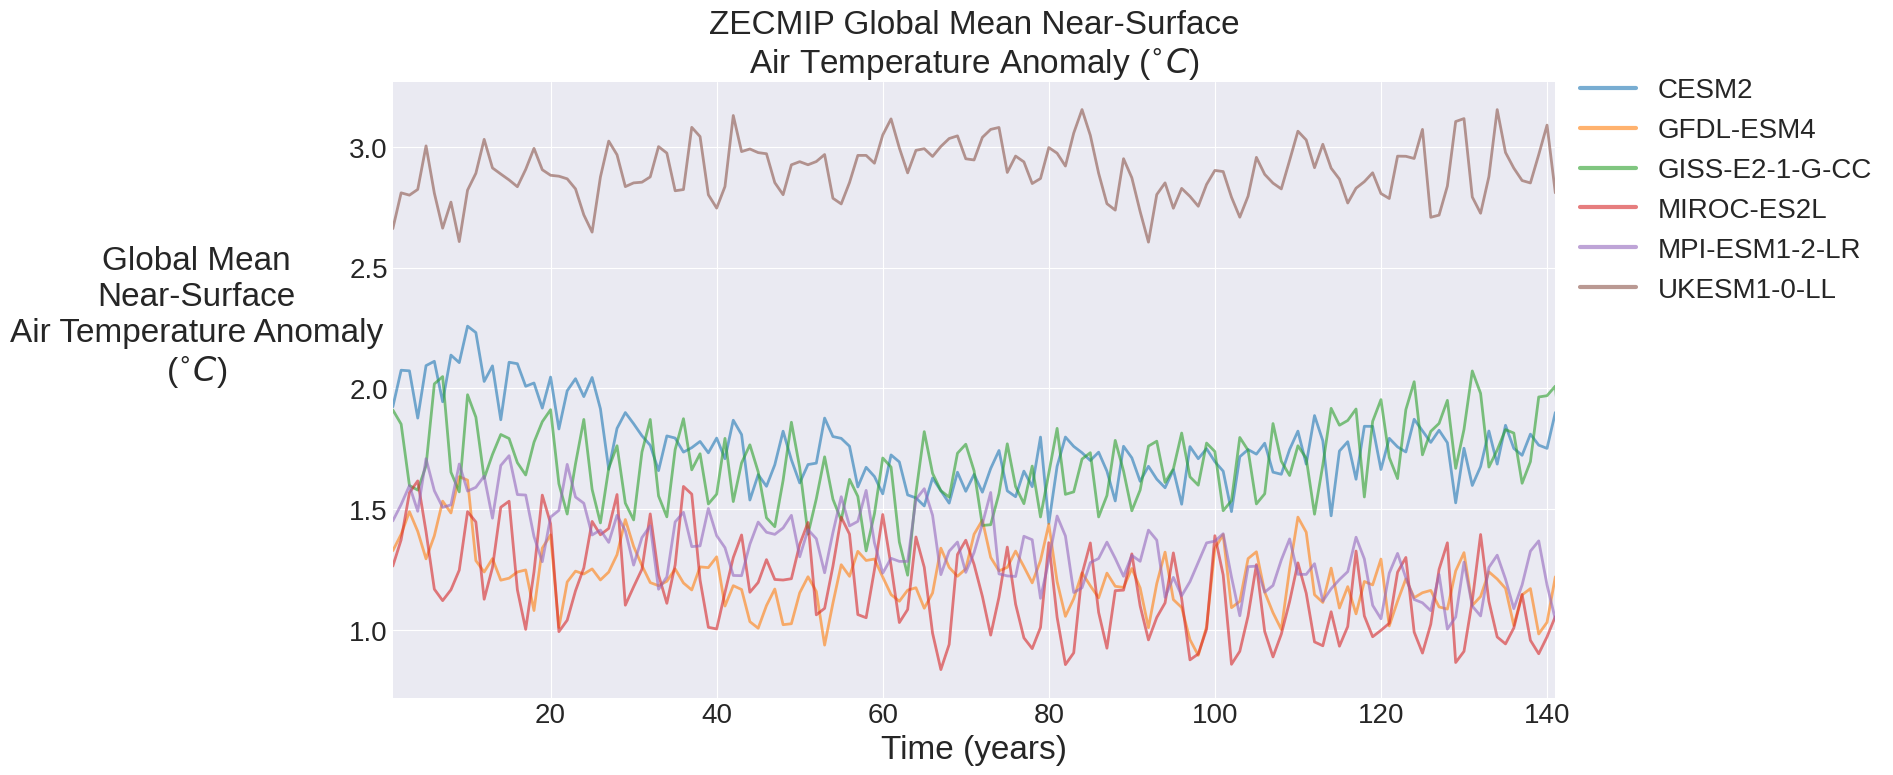

In [111]:

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = experiment_smean_ds['time'].values
years = [t.year for t in time]
for model in list(experiment_smean_ds.model.values):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, experiment_smean_ds.sel(model=model).tas.values, label=model, **plot_kwargs)
    
ax.set_ylabel(f'{hemisphere_title} Mean\n{longname} Anomaly\n({units})', size=24, labelpad=110, rotation=0)
ax.set_xlabel('Time (years)', size=24)
ax.set_xlim(years[0], years[140])
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
leg = ax.legend(ncol = 1, fontsize=20, bbox_to_anchor=[1.0,0.6])
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title(f'ZECMIP {hemisphere_title} Mean {longname} Anomaly ({units})', fontsize=24);

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 'zec_03_multi_model_experiment.png'), 
            bbox_inches='tight')